### Import Libraries

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import time

import imblearn.over_sampling
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

### Read in the pickle file 

In [2]:
df3 = pd.read_pickle('latest_df.pkl')

In [3]:
df3

,index,id,app_name,size_bytes,currency,price,rating_count,rating_count_ver,user_rating,userrating_ver,...,Productivity,Reference,Shopping,Social Networking,Sports,Travel,Utilities,Weather,Paid/Free,version
0,1,281656475,PAC-MAN Premium,100788224.0,USD,3.99,21292,26,4.0,4.5,...,0,0,0,0,0,0,0,0,1,6
1,2,281796108,Evernote - stay organized,158578688.0,USD,0.00,161065,26,4.0,3.5,...,1,0,0,0,0,0,0,0,0,8
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032.0,USD,0.00,188583,2822,3.5,4.5,...,0,0,0,0,0,0,0,1,0,5
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000.0,USD,0.00,262241,649,4.0,4.5,...,0,0,1,0,0,0,0,0,0,5
4,5,282935706,Bible,92774400.0,USD,0.00,985920,5320,4.5,5.0,...,0,1,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,11081,1187617475,Kubik,126644224.0,USD,0.00,142,75,4.5,4.5,...,0,0,0,0,0,0,0,0,0,1
7193,11082,1187682390,VR Roller-Coaster,120760320.0,USD,0.00,30,30,4.5,4.5,...,0,0,0,0,0,0,0,0,0,0
7194,11087,1187779532,Bret Michaels Emojis + Lyric Keyboard,111322112.0,USD,1.99,15,0,4.5,0.0,...,0,0,0,0,0,0,1,0,1,1
7195,11089,1187838770,VR Roller Coaster World - Virtual Reality,97235968.0,USD,0.00,85,32,4.5,4.5,...,0,0,0,0,0,0,0,0,0,1


### Createa a train/test split and then cross validation on models

In [4]:
Target = df3['popular']
Features = (df3[['price','content_rating','ipad_screenshot', 'lang_num', 
                 'support_devices','Education', 'Entertainment', 'Games']])

In [5]:
Features, Features_test, Target, Target_test = train_test_split(Features, Target, test_size=.2, random_state=14) 

Features, Target = np.array(Features), np.array(Target)

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 39)

f1_log, f1_knn, f1_svc, f1_rfc, f1_dc, f1_gb  = [], [], [], [], [], []
r_log, r_knn, r_svc, r_rfc, r_dc, r_gb = [], [], [], [], [], []
p_log, p_knn, p_svc, p_rfc, p_dc, p_gb = [], [], [], [], [], []
roc_log, roc_knn, roc_svc, roc_rfc, roc_dc, roc_gb = [], [], [], [], [], []


for train_ind, val_ind in skf.split(Features, Target):
    
    Features_train, Target_train = Features[train_ind], Target[train_ind]
    Features_val, Target_val = Features[val_ind], Target[val_ind] 
    
    n_pos = np.sum(Target_train == 1)
    n_neg = np.sum(Target_train == 0)
    ratio = {1 : n_pos * 5, 0 : n_neg}
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    Features_train, Target_train = ROS.fit_sample(Features_train, Target_train)

    #scaler
    scaler = StandardScaler()
    Features_train_scaled = scaler.fit_transform(Features_train)
    Features_val_scaled = scaler.transform(Features_val)
    
    #KNN 
    knn = KNeighborsClassifier()
    knn.fit(Features_train_scaled, Target_train)
    train_predict = knn.predict(Features_val_scaled)
    p_knn.append(precision_score(Target_val, train_predict))
    f1_knn.append(f1_score(Target_val, train_predict))
    r_knn.append(recall_score(Target_val, train_predict))
    roc_knn.append(roc_auc_score(Target_val, knn.predict_proba(Features_val_scaled)[:,1]))
    
    #logistic regression
    lm = LogisticRegression()
    lm.fit(Features_train_scaled, Target_train)
    train_predict = (lm.predict_proba(Features_val_scaled)[:, 1] > 0.6)
    p_log.append(precision_score(Target_val, train_predict))
    f1_log.append(f1_score(Target_val, train_predict))
    r_log.append(recall_score(Target_val, train_predict))
    roc_log.append(roc_auc_score(Target_val, lm.predict_proba(Features_val_scaled)[:,1]))
    
    #SVC
    svc = SVC()
    svc.fit(Features_train, Target_train)
    train_predict = svc.predict(Features_val)
    p_svc.append(precision_score(Target_val, train_predict))
    f1_svc.append(f1_score(Target_val, train_predict))
    r_svc.append(recall_score(Target_val, train_predict))
    roc_svc.append(roc_auc_score(Target_val, knn.predict_proba(Features_val)[:,1]))
    
    #Randomforest
    rfc = RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=100, criterion='entropy')
    rfc.fit(Features_train, Target_train)
    train_predict = (rfc.predict_proba(Features_val)[:, 1] >= 0.50)
    p_rfc.append(precision_score(Target_val, train_predict))
    f1_rfc.append(f1_score(Target_val, train_predict))
    r_rfc.append(recall_score(Target_val, train_predict))
    roc_rfc.append(roc_auc_score(Target_val, rfc.predict_proba(Features_val)[:,1]))
    
    #dummy model
    dummy_clf = DummyClassifier()
    dummy_clf.fit(Features_train, Target_train)
    train_predict = dummy_clf.predict(Features_val)
    p_dc.append(precision_score(Target_val, train_predict))
    f1_dc.append(f1_score(Target_val, train_predict))
    r_dc.append(recall_score(Target_val, train_predict))
    roc_dc.append(roc_auc_score(Target_val, dummy_clf.predict_proba(Features_val)[:,1]))
    
    #gaussian bayes
    gb = GaussianNB()
    gb.fit(Features_train, Target_train)
    train_predict = gb.predict(Features_val)
    p_gb.append(precision_score(Target_val, train_predict))
    f1_gb.append(f1_score(Target_val, train_predict))
    r_gb.append(recall_score(Target_val, train_predict))
    roc_gb.append(roc_auc_score(Target_val, gb.predict_proba(Features_val)[:,1]))
    

/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/Users/michaelpaig/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change fro

#### Print out the scores for the each of the models

In [7]:
print(f'Log F1: {np.mean(f1_log):.3f}')
print(f'KNN F1: {np.mean(f1_knn):.3f}')
print(f'SVC F1: {np.mean(f1_svc):.3f}')
print(f'Dummy F1: {np.mean(f1_dc):.3f}')
print(f'Gaussian Bayes F1: {np.mean(f1_gb):.3f}')
print(f'RandomForest F1: {np.mean(f1_rfc,):.3f}', '\n')

print(f'Log precision: {np.mean(p_log):.3f}')
print(f'KNN precision: {np.mean(p_knn):.3f}')
print(f'SVC precision: {np.mean(p_knn):.3f}')
print(f'Dummyy precision: {np.mean(p_dc):.3f}')
print(f'Gaussian precision: {np.mean(p_gb):.3f}')
print(f'RandomForest precision: {np.mean(p_rfc):.3f}', '\n')

print(f'Log recall: {np.mean(r_log):.3f}')
print(f'KNN recall: {np.mean(r_knn):.3f}')
print(f'SVC recall: {np.mean(r_svc):.3f}')
print(f'Dummy recall: {np.mean(r_dc):.3f}')
print(f'Gaussian recall: {np.mean(r_gb):.3f}')
print(f'RandomForest recall: {np.mean(r_rfc):.3f}', '\n')

print(f'Log roc auc: {np.mean(roc_log):.3f}')
print(f'KNN roc auc: {np.mean(roc_knn):.3f}')
print(f'SVC roc auc: {np.mean(roc_svc):.3f}')
print(f'Dummy roc auc: {np.mean(roc_dc):.3f}')
print(f'Gaussian roc auc: {np.mean(roc_gb):.3f}')
print(f'RandomForest roc auc: {np.mean(roc_rfc):.3f}', '\n')


Log F1: 0.345
KNN F1: 0.325
SVC F1: 0.365
Dummy F1: 0.222
Gaussian Bayes F1: 0.273
RandomForest F1: 0.410 

Log precision: 0.354
KNN precision: 0.263
SVC precision: 0.263
Dummyy precision: 0.146
Gaussian precision: 0.163
RandomForest precision: 0.347 

Log recall: 0.337
KNN recall: 0.426
SVC recall: 0.474
Dummy recall: 0.467
Gaussian recall: 0.855
RandomForest recall: 0.509 

Log roc auc: 0.713
KNN roc auc: 0.686
SVC roc auc: 0.454
Dummy roc auc: 0.507
Gaussian roc auc: 0.682
RandomForest roc auc: 0.767 



### Final model chosen is Random Forest and now applying to our test set

In [8]:
n_pos = np.sum(Target == 1)
n_neg = np.sum(Target == 0)
ratio = {1 : n_pos * 6, 0 : n_neg}
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
Features, Target = ROS.fit_sample(Features, Target)

In [9]:
rfc = RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=100, criterion='entropy')

rfc.fit(Features, Target)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features='log2')

In [12]:
train_predict = rfc.predict(Features_test)
print(precision_score(Target_test, train_predict))
print(f1_score(Target_test, train_predict))
print(roc_auc_score(Target_test, rfc.predict_proba(Features_test)[:,1]))

0.34025974025974026
0.43666666666666665
0.7752083531086853


### Confusion Matrix from the Random Forest

In [16]:
def make_confusion_matrix(model):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = model.predict(Features_test)
    fraud_confusion = confusion_matrix(Target_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['not', 'popular'],
           yticklabels=['not', 'popular']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

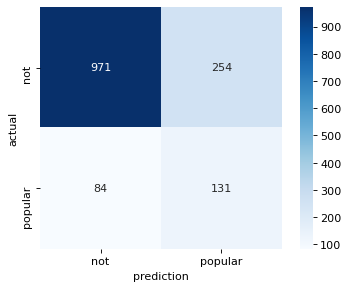

In [17]:
make_confusion_matrix(rfc)